# Brewing Logistic Regression then Going Deeper

While Caffe is made for deep networks it can likewise represent "shallow" models like logistic regression for classification. We'll do simple logistic regression on synthetic data that we'll generate and save to HDF5 to feed vectors to Caffe. Once that model is done, we'll add layers to improve accuracy. That's what Caffe is about: define a model, experiment, and then deploy.

### 1. Setup

* Python usual setup with `numpy`, and `matplotlib`.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# display the plot inline in this notebook
%matplotlib inline

* Load `caffe`.

In [3]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import os
os.chdir('..')
import sys
caffe_root = '/home/NAME/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe # If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

* Load additional useful lib.

In [ ]:
import h5py
import shutil
import tempfile

import sklearn
import sklearn.datasets
import sklearn.linear_model

import pandas as pd

# Visualize net
from google.protobuf import text_format
from caffe.draw import get_pydot_graph
from caffe.proto import caffe_pb2
from IPython.display import display, Image 


sklearn.__version__

### 2. Load the dataset

We load the dataset used in the previous lab *Data scientist for a day* 

In [5]:
 train_data = pd.read_csv('DeepLearning/train.csv', header=None)
 train_labels = pd.read_csv('DeepLearning/trainLabels.csv', header=None)
 test_data = pd.read_csv('DeepLearning/test.csv', header=None)
 X = np.asarray(train_data)
 y = np.asarray(train_labels).ravel()
 X_test= np.asarray(test_data)

# Split into train and test
X, Xt, y, yt = sklearn.cross_validation.train_test_split(X, y)

Data enters Caffe through data layers: they lie at the bottom of nets. Data can come from efficient databases (LevelDB or LMDB), directly from memory, or, when efficiency is not critical, from files on disk in HDF5 or common image formats.
HDF5 is a Hierarchical Data Format consisting of a data format specification and a supporting library implementation. 

Next we save the dataset to HDF5 for loading in Caffe.

In [6]:
# Write out the data to HDF5 files in a temp directory.
# This file is assumed to be caffe_root/examples/hdf5_classification.ipynb
dirname = os.path.abspath('./DeepLearning/hdf5_classification/data')
if not os.path.exists(dirname):
    os.makedirs(dirname)

train_filename = os.path.join(dirname, 'train.h5')
test_filename = os.path.join(dirname, 'test.h5')
submission_filename = os.path.join(dirname, 'submission.h5')


# HDF5DataLayer source should be a file containing a list of HDF5 filenames.
# To show this off, we'll list the same data file twice.
with h5py.File(train_filename, 'w') as f:
    f['data'] = X
    f['label'] = y.astype(np.float32)
with open(os.path.join(dirname, 'train.txt'), 'w') as f:
    f.write(train_filename + '\n')
    f.write(train_filename + '\n')
    
# HDF5 is pretty efficient, but can be further compressed.
comp_kwargs = {'compression': 'gzip', 'compression_opts': 1}
with h5py.File(test_filename, 'w') as f:
    f.create_dataset('data', data=Xt, **comp_kwargs)
    f.create_dataset('label', data=yt.astype(np.float32), **comp_kwargs)
with open(os.path.join(dirname, 'test.txt'), 'w') as f:
    f.write(test_filename + '\n')
    
with h5py.File(submission_filename, 'w') as f:
    f.create_dataset('data', data=X_test, **comp_kwargs)
with open(os.path.join(dirname, 'submission.txt'), 'w') as f:
    f.write(submission_filename + '\n')

### 3. Simple logistic regressor

Let's define logistic regression in Caffe through Python net specification. 

![Test](logistic.png "Test")

This is a quick and natural way to define nets that sidesteps manually editing the protobuf model. A network is a set of layers and their connections. Caffe creates and checks the net from the definition.
Data and derivatives flow through the net as blobs that is an array interface

Blobs are N-D arrays for storing and communicating information.
* hold data, derivatives, and parameters
* lazily allocate memory
* shuttle between CPU and GPU



In [7]:
from caffe import layers as L
from caffe import params as P

def logreg(hdf5, batch_size):
    # logistic regression: data, matrix multiplication, and 2-class softmax loss
    n = caffe.NetSpec()
    n.data, n.label = L.HDF5Data(batch_size=batch_size, source=hdf5, ntop=2)
    n.ip1 = L.InnerProduct(n.data, num_output=2, weight_filler=dict(type='xavier'))
    n.accuracy = L.Accuracy(n.ip1, n.label)
    n.loss = L.SoftmaxWithLoss(n.ip1, n.label)
    return n.to_proto()

train_net_path = 'DeepLearning/hdf5_classification/logreg_auto_train.prototxt'
with open(train_net_path, 'w') as f:
    f.write(str(logreg('DeepLearning/hdf5_classification/data/train.txt', 10)))

test_net_path = 'DeepLearning/hdf5_classification/logreg_auto_test.prototxt'
with open(test_net_path, 'w') as f:
    f.write(str(logreg('DeepLearning/hdf5_classification/data/test.txt', 10)))

* Let's visualize the network graph

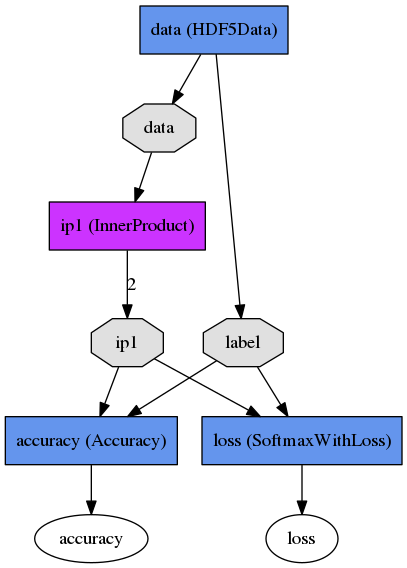

In [8]:
def view_graph(prototxt):
    _net = caffe_pb2.NetParameter()
    f = open(prototxt)
    text_format.Merge(f.read(), _net)
    display(Image(get_pydot_graph(_net,"TB").create_png()))
    
view_graph("DeepLearning/hdf5_classification/logreg_auto_test.prototxt")

___
* Do you notice any differences respect the previous graph?
* What's the meaning of the "2" above ip1 node?
* Where are the `blobs`?
___

#### Define the solver
Now, we'll define our "solver" which trains the network by specifying the locations of the train and test nets we defined above, as well as setting values for various parameters used for learning, display, and "snapshotting".

In [9]:
from caffe.proto import caffe_pb2

class create_solver(object):
    def __init__(self, train_net_path, test_net_path):
        self.train_net_path = train_net_path
        self.test_net_path = test_net_path
        
        self.define_solver()
    
    def define_solver(self):
        self.s = caffe_pb2.SolverParameter()

        # Specify locations of the train and test networks.
        self.s.train_net = self.train_net_path
        self.s.test_net.append(self.test_net_path)

        self.s.test_interval = 100  # Test after every 100 training iterations.
        self.s.test_iter.append(250) # Test 250 "batches" each time we test.

        self.s.max_iter = 10000      # # of times to update the net (training iterations)

        # Set the initial learning rate for stochastic gradient descent (SGD).
        self.s.base_lr = 0.1        
        # Set `lr_policy` to define how the learning rate changes during training.
        # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
        # every `stepsize` iterations.
        self.s.lr_policy = 'step'
        self.s.gamma = 0.1
        self.s.stepsize = 5000

        # Set other optimization parameters. Setting a non-zero `momentum` takes a
        # weighted average of the current gradient and previous gradients to make
        # learning more stable. L2 weight decay regularizes learning, to help prevent
        # the model from overfitting.
        self.s.momentum = 0.9
        self.s.weight_decay = 5e-4

        # Display the current training loss and accuracy every 1000 iterations.
        self.s.display = 100

        # Snapshots are files used to store networks we've trained.  Here, we'll
        # snapshot every 10K iterations -- just once at the end of training.
        # For larger networks that take longer to train, you may want to set
        # snapshot < max_iter to save the network and training state to disk during
        # optimization, preventing disaster in case of machine crashes, etc.
        self.s.snapshot = 10000
        self.s.snapshot_prefix = 'DeepLearning/hdf5_classification/data/train'

        # We'll train on the CPU for fair benchmarking against scikit-learn.
        # Changing to GPU should result in much faster training!
        self.s.solver_mode = caffe_pb2.SolverParameter.CPU

        return self.s

    def write_solver(self, solver_path):
        with open(solver_path, 'w') as f:
            f.write(str(self.s))
        
solver_path = 'DeepLearning/hdf5_classification/logreg_solver.prototxt'
s = create_solver(train_net_path, test_net_path)       
s.write_solver(solver_path)

Time to learn and evaluate our Caffeinated logistic regression in Python.    

In [ ]:
#%%timeit
caffe.set_mode_cpu()
solver = caffe.get_solver(solver_path)
solver.solve()

accuracy = 0
batch_size = solver.test_nets[0].blobs['data'].num
test_iters = int(len(Xt) / batch_size)
for i in range(test_iters):
    solver.test_nets[0].forward()
    accuracy += solver.test_nets[0].blobs['accuracy'].data
accuracy /= test_iters

print("Accuracy: {:.3f}".format(accuracy))

### Visualization 
It's very simple to access to the weight, parameters, and intermediate results that are attached to a network graph.

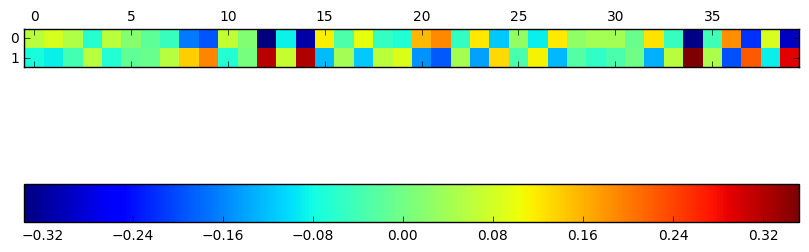

In [10]:
# weights connecting the input with ip1
arr = solver.net.params["ip1"][0].data

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(arr, interpolation='none')
fig.colorbar(cax, orientation="horizontal")

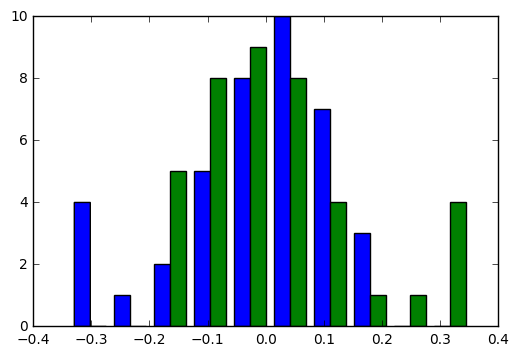

In [11]:
_ = plt.hist(arr.tolist(), bins=10)

### Best parameters
Now try to hack the code above in order to find the best parameters (remember the previous lab, and how perform a grid search). I'm shure you could reach at least an accuracy of: `0.876`

In [ ]:
# Hint: edit the parameters by directly access the create_solver class data structure 
s = create_solver(train_net_path, test_net_path)       
s.s.base_lr = 0.1                      # change the learning rate
s.write_solver(solver_path)            # recreate the solver prototxt


[...]

* What is the impact of `learning rate` and `weight decay` regularization?

You could always do the same through the command line interface, for detailed output on the model and solving. Remember to correctly change the path according to your directories tree

In [ ]:
!/home/NAME/caffe/build/tools/caffe train -solver DeepLearning/hdf5_classification/logreg_solver.prototxt

### 4. Non linearity

If you look at output or the `logreg_auto_train.prototxt`, you'll see that the model is simple logistic regression.
We can make it a little more advanced by introducing a non-linearity between weights that take the input and weights that give the output -- now we have a two-layer network.
That network is given in `nonlinear_auto_train.prototxt`, and that's the only change made in `nonlinear_logreg_solver.prototxt` which we will now use.

The final accuracy of the new network should be higher than logistic regression!

In [11]:
from caffe import layers as L
from caffe import params as P

def nonlinear_net(hdf5, batch_size, dim):
    # one small nonlinearity, one leap for model kind
    n = caffe.NetSpec()
    n.data, n.label = L.HDF5Data(batch_size=batch_size, source=hdf5, ntop=2)
    # define a hidden layer of dimension 40
    n.ip1 = L.InnerProduct(n.data, num_output=dim, weight_filler=dict(type='xavier'))
    # transform the output through the ReLU (rectified linear) non-linearity
    n.relu1 = L.ReLU(n.ip1, in_place=True)
    # score the (now non-linear) features
    n.ip2 = L.InnerProduct(n.ip1, num_output=2, weight_filler=dict(type='xavier'))
    # same accuracy and loss as before
    n.accuracy = L.Accuracy(n.ip2, n.label)
    n.loss = L.SoftmaxWithLoss(n.ip2, n.label)
    return n.to_proto()

def predict_net(hdf5, batch_size,dim):
    # one small nonlinearity, one leap for model kind
    n = caffe.NetSpec()
    n.data = L.HDF5Data(batch_size=batch_size, source=hdf5, ntop=1)
    # define a hidden layer of dimension 40
    n.ip1 = L.InnerProduct(n.data, num_output=dim, weight_filler=dict(type='xavier'))
    # transform the output through the ReLU (rectified linear) non-linearity
    n.relu1 = L.ReLU(n.ip1, in_place=True)
    # score the (now non-linear) features
    n.ip2 = L.InnerProduct(n.ip1, num_output=2, weight_filler=dict(type='xavier'))
    # same accuracy and loss as before
    return n.to_proto()

train_net_path = 'DeepLearning/hdf5_classification/nonlinear_auto_train.prototxt'
with open(train_net_path, 'w') as f:
    f.write(str(nonlinear_net('DeepLearning/hdf5_classification/data/train.txt', 10, 40)))

test_net_path = 'DeepLearning/hdf5_classification/nonlinear_auto_test.prototxt'
with open(test_net_path, 'w') as f:
    f.write(str(nonlinear_net('DeepLearning/hdf5_classification/data/test.txt', 10, 40)))
    
submission_net_path = 'DeepLearning/hdf5_classification/nonlinear_auto_submission.prototxt'
with open(submission_net_path, 'w') as f:
    f.write(str(predict_net('DeepLearning/hdf5_classification/data/submission.txt', 10, 40)))

solver_path = 'DeepLearning/hdf5_classification/nonlinear_logreg_solver.prototxt'
s = create_solver(train_net_path, test_net_path)
s.s.base_lr = 0.01
s.write_solver(solver_path)

Visualize the network graph.

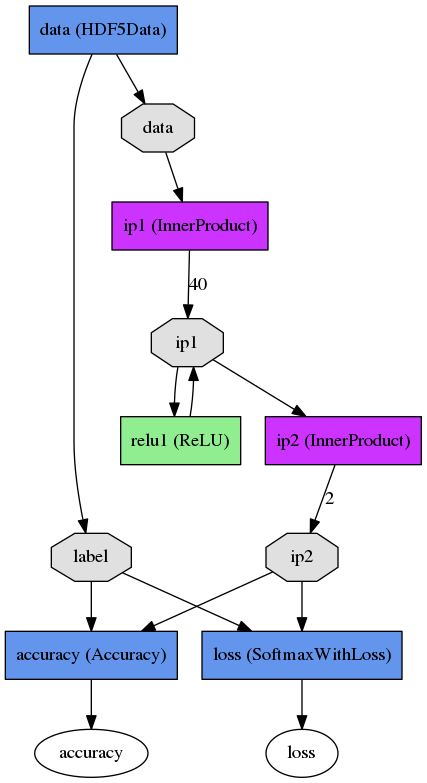

In [12]:
view_graph("DeepLearning/hdf5_classification/nonlinear_auto_test.prototxt")

In [ ]:
# It's your turn
# Try to improve your score!

[...]

* Find the best parameters!
* Can you breake the wall of `0.9` of accuracy?

### 5. Let's go deeper

Try to pack many layers in order to increase your model capacity. But pay attention that, the more you increase your model's capacity, the more you could overfit your training data!
Look carefully at the image below:
![Capacity](capacity.png "Capacity")

* Have you got the point? Now try to create a model with an optimal capacity according to you data. 

In [57]:
from caffe import layers as L
from caffe import params as P


def nonlinear_net(hdf5, batch_size):
    # one small nonlinearity, one leap for model kind
    n = caffe.NetSpec()
    n.data, n.label = L.HDF5Data(batch_size=batch_size, source=hdf5, ntop=2)
    # define a hidden layer of dimension 40
    n.ip1 = L.InnerProduct(n.data, num_output=40, weight_filler=dict(type='xavier'))
    # transform the output through the ReLU (rectified linear) non-linearity
    n.relu1 = L.ReLU(n.ip1, in_place=True)
    
    # define a hidden layer of dimension 20
    n.ip2 = L.InnerProduct(n.ip1, num_output=20, weight_filler=dict(type='xavier'))
    # transform the output through the ReLU (rectified linear) non-linearity
    n.relu2 = L.ReLU(n.ip2, in_place=True)
    # define a hidden layer of dimension 10
    n.ip3 = L.InnerProduct(n.ip2, num_output=10, weight_filler=dict(type='xavier'))
    # transform the output through the ReLU (rectified linear) non-linearity
    n.relu3 = L.ReLU(n.ip3, in_place=True)
    
    # define a hidden layer of dimension 5
    n.ip4 = L.InnerProduct(drop, num_output=5, weight_filler=dict(type='xavier'))
    # transform the output through the ReLU (rectified linear) non-linearity
    n.relu4 = L.ReLU(n.ip4, in_place=True)
    
    # score the (now non-linear) features
    n.ip5 = L.InnerProduct(n.ip4, num_output=2, weight_filler=dict(type='xavier'))
    # same accuracy and loss as before
    n.accuracy = L.Accuracy(n.ip4, n.label)
    n.loss = L.SoftmaxWithLoss(n.ip4, n.label)
    return n.to_proto()

def predict_net(hdf5, batch_size):
    # one small nonlinearity, one leap for model kind
    n = caffe.NetSpec()
    n.data = L.HDF5Data(batch_size=batch_size, source=hdf5, ntop=1)
    # define a hidden layer of dimension 40
    n.ip1 = L.InnerProduct(n.data, num_output=40, weight_filler=dict(type='xavier'))
    # transform the output through the ReLU (rectified linear) non-linearity
    n.relu1 = L.ReLU(n.ip1, in_place=True)
    
    # define a hidden layer of dimension 20
    n.ip2 = L.InnerProduct(n.ip1, num_output=20, weight_filler=dict(type='xavier'))
    # transform the output through the ReLU (rectified linear) non-linearity
    n.relu2 = L.ReLU(n.ip2, in_place=True)
    # define a hidden layer of dimension 10
    n.ip3 = L.InnerProduct(n.ip2, num_output=10, weight_filler=dict(type='xavier'))
    # transform the output through the ReLU (rectified linear) non-linearity
    n.relu3 = L.ReLU(n.ip3, in_place=True)
    # define a hidden layer of dimension 5
    n.ip4 = L.InnerProduct(n.ip3, num_output=5, weight_filler=dict(type='xavier'))
    # transform the output through the ReLU (rectified linear) non-linearity
    n.relu4 = L.ReLU(n.ip4, in_place=True)
    
    # score the (now non-linear) features
    n.ip5 = L.InnerProduct(n.ip4, num_output=2, weight_filler=dict(type='xavier'))
    # same accuracy and loss as before
    return n.to_proto()

train_net_path = 'DeepLearning/hdf5_classification/nonlinear_auto_train.prototxt'
with open(train_net_path, 'w') as f:
    f.write(str(nonlinear_net('DeepLearning/hdf5_classification/data/train.txt', 10)))

test_net_path = 'DeepLearning/hdf5_classification/nonlinear_auto_test.prototxt'
with open(test_net_path, 'w') as f:
    f.write(str(nonlinear_net('DeepLearning/hdf5_classification/data/test.txt', 10)))
    
submission_net_path = 'DeepLearning/hdf5_classification/nonlinear_auto_submission.prototxt'
with open(submission_net_path, 'w') as f:
    f.write(str(predict_net('DeepLearning/hdf5_classification/data/submission.txt', 10)))

solver_path = 'DeepLearning/hdf5_classification/nonlinear_logreg_solver.prototxt'
s = create_solver(train_net_path, test_net_path)
s.s.base_lr = 0.01
s.write_solver(solver_path)

In [ ]:
%%timeit
caffe.set_mode_cpu()
solver = caffe.get_solver(solver_path)
solver.solve()

accuracy = 0
batch_size = solver.test_nets[0].blobs['data'].num
test_iters = int(len(Xt) / batch_size)
for i in range(test_iters):
    solver.test_nets[0].forward()
    accuracy += solver.test_nets[0].blobs['accuracy'].data
accuracy /= test_iters

print("Accuracy: {:.3f}".format(accuracy))

### Plotting learning curves

There are many way to produce data to be used in order to plot the learning curve. One of these is to export the output of the learning phase in a file, and then parse it with `parse_log.py` script, that it is already provided in caffe.

**!Remember to edit the path**

In [ ]:
!/home/NAME/caffe/build/tools/caffe train -solver DeepLearning/hdf5_classification/nonlinear_logreg_solver.prototxt 2>&1 | tee lenet_train.log

In [61]:
!python /home/NAME/caffe/tools/extra/parse_log.py lenet_train.log .

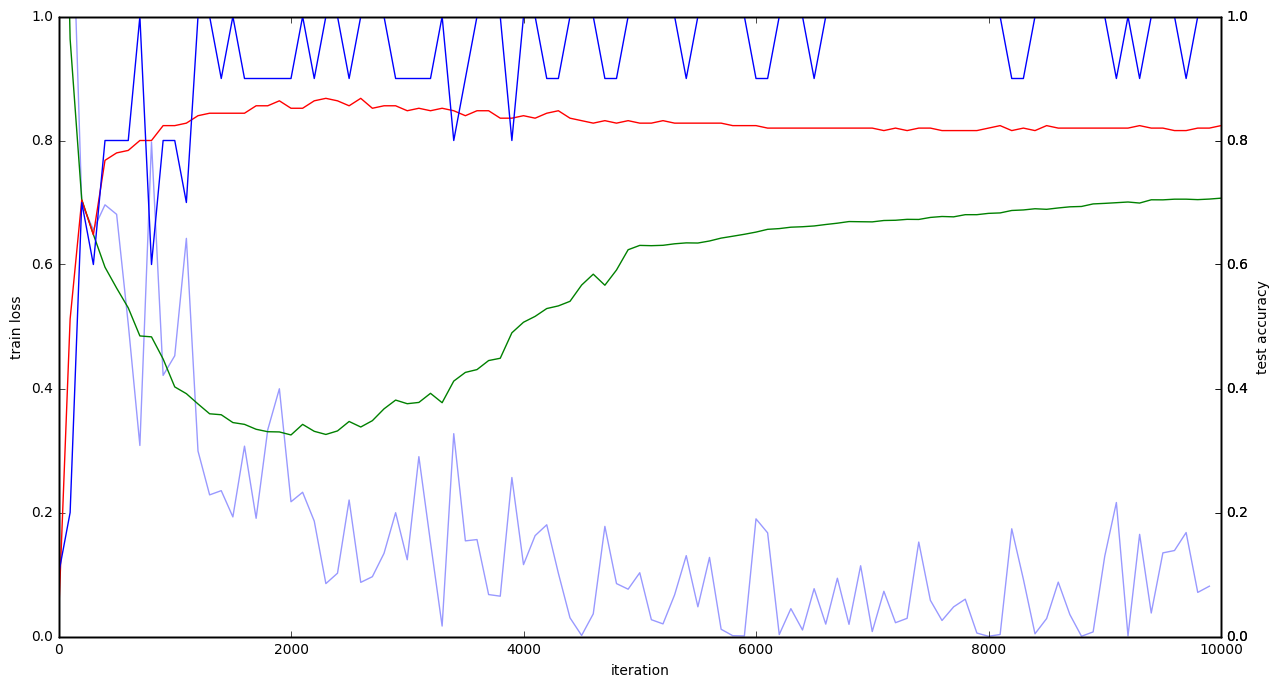

In [62]:
train_log = pd.read_csv("./lenet_train.log.train")
test_log = pd.read_csv("./lenet_train.log.test")
_, ax1 = plt.subplots(figsize=(15, 8))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

ax1.plot(train_log["NumIters"], train_log["loss"], alpha=0.4)
ax1.plot(test_log["NumIters"], test_log["loss"], 'g')
ax2.plot(test_log["NumIters"], test_log["accuracy"], 'r')
ax3.plot(train_log["NumIters"], train_log["accuracy"], 'b')

# try to add also the LearningRate!

ax1.axis([0, 10000, 0, 1])
ax2.axis([0, 10000, 0, 1])
ax3.axis([0, 10000, 0, 1])

ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')

## Ready for the submission?

Let's try a prediction! In order to do it, you just need to initialize `caffe.Net` with the prototxt and the trained model.

In [64]:
net = caffe.Net ('DeepLearning/hdf5_classification/nonlinear_auto_submission.prototxt',
                 'DeepLearning/hdf5_classification/data/train_iter_10000.caffemodel',
                caffe.TEST)

Finally, you call the `forward()` method for each sample.

In [65]:
labels = []
for i in xrange(900):
    pred = net.forward()
    labels.append(net.blobs['ip3'].data[...].argmax(axis=1))

* How the output looks like?
* What does the `.argmax()`?
* Try to reshape the `labels` in order to have a vector 1x9000 (Recall numpy Lab)

In [68]:
y_pred = np.array(labels).reshape(9000)

In [69]:
with open('submission.csv', 'wb') as csvfile:
    for i in xrange(9000):
        csvfile.write("{0},".format(int(y_pred[i])))

In [ ]:
# Clean up (comment this out if you want to examine the hdf5_classification/data directory).
shutil.rmtree(dirname)